# Analyzing images with Azure Content Safety

## Use-case: images defect detection
### Part 2: Azure openAI gpt-4o baseline model for image classification

Six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., **rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc)**. 

> https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database

We will use in this notebook the gpt-4o Azure OpenAI baseline model. Then in another notebook we will do some fine tuning of gpt-4o with Azure OpenAI.

<img src="neu.png">

In [1]:
import base64
import glob
import ipyplot
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import seaborn as sns
import sys

from datetime import datetime
from dotenv import load_dotenv
from mimetypes import guess_type
from openai import AzureOpenAI
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Azure OpenAI version: {openai.__version__}")

Azure OpenAI version: 1.59.6


In [4]:
now = datetime.now()
today = now.strftime("%Y-%m-%d %H:%M:%S")
print(f"Today is {today}")

Today is 2025-01-22 11:18:06


In [5]:
load_dotenv("azure.env")

aoai_key = os.getenv("api_key")
aoai_endpoint = os.getenv("azure_endpoint")

model = "gpt-4o"

## 1 Helper

In [33]:
def count_image_files(path):
    """
    Counts and prints the number of image files in each subdirectory of the given directory.

    Args:
        path (str): The path to the directory to search for image files.
    """
    image_extensions = {'.jpg', '.jpeg', '.png', '.webp'}
    nb_images = 0

    for root, dirs, files in os.walk(path):
        dirs[:] = [d for d in dirs if d != '.ipynb_checkpoints']
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            num_image_files = len([f for f in os.listdir(subdir_path) 
                                   if os.path.isfile(os.path.join(subdir_path, f)) and 
                                   os.path.splitext(f)[1].lower() in image_extensions])
            print(f"{subdir_path} | Number of image files = {num_image_files}")
            nb_images += num_image_files

    return nb_images

In [7]:
def display_image(image_file):
    """
    Display an image file.

    This function checks if the specified image file exists. 
    If the file exists, it opens and displays the image.
    If the file does not exist, it prints an error message.

    Parameters:
    image_file (str): The path to the image file to be displayed.
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        print(f"Image file to classify: {image_file}")
        img = Image.open(image_file)
        display(img)

In [8]:
def local_image_to_url(image_file):
    """
    Convert a local image file to a data URL.

    This function checks if the specified image file exists. If the file exists, it reads the file,
    encodes its content in base64, and returns a data URL that can be used to embed the image in web pages.
    If the file does not exist, it prints an error message and returns None.
    """
    if not os.path.exists(image_file):
        print(f"[Error] Image file {image_file} does not exist.")
        return None

    else:
        mime_type, _ = guess_type(image_file)
        if mime_type is None:
            mime_type = 'application/octet-stream'  # Default MIME type if none is found
        with open(image_file, "rb") as imagefile:
            base64_encoded_data = base64.b64encode(
                imagefile.read()).decode('utf-8')
        return f"data:{mime_type};base64,{base64_encoded_data}"

In [9]:
def get_image_classification(image_file, model=model):
    """
    Classify an image using an Azure OpenAI model.

    This function takes an image file and uses an Azure OpenAI model to classify the image.
    It constructs a prompt for the model to analyze the image and return a classification from a 
    predefined list of classes.
    If the model cannot determine the class, it returns 'unknown'.

    Parameters:
    image_file (str): The path to the image file to be classified.
    model (str): The name of the Azure OpenAI model to be used for classification.

    Returns:
    str: The classification result from the model.
    """
    aoai_client = AzureOpenAI(api_key=aoai_key,
                              api_version="2024-10-21",
                              azure_endpoint=aoai_endpoint)

    prompt = f"""
    Analyze the provided image of metal surfaces. There are six classes of metal defects in the surface: {class_labels}.
    You must always return only one word value from that list. If you do not know, always choose 'unknown'.
    """

    response = aoai_client.chat.completions.create(
        model=model,
        messages=[{
            "role": "system",
            "content": "You are a helpful assistant to analyse image."
        }, {
            "role":
            "user",
            "content": [{
                "type": "text",
                "text": prompt
            }, {
                "type": "image_url",
                "image_url": {
                    "url": f"{local_image_to_url(image_file)}"
                }
            }]
        }],
        max_tokens=800,
        temperature=0.,
        top_p=1,
        presence_penalty=1,
    )

    return response.choices[0].message.content

## 2 Image classification with gpt-4o baseline model

In [10]:
IMAGES_DIR = "defects_images"

In [34]:
count_image_files(IMAGES_DIR)

defects_images/class1 | Number of image files = 273
defects_images/class2 | Number of image files = 270
defects_images/class3 | Number of image files = 272
defects_images/class4 | Number of image files = 269
defects_images/class5 | Number of image files = 276
defects_images/class6 | Number of image files = 252


1612

In [12]:
images = glob.glob(IMAGES_DIR +  '/**/*.*')
labels = [image.split('/')[-2] for image in images]

ipyplot.plot_class_tabs(images, labels, max_imgs_per_tab=5, img_width=160)

In [13]:
class_id = ["class1", "class2", "class3", "class4", "class5", "class6"]
class_labels = ["rolled", "pitted", "patches", "inclusion", "crazing", "scratches"]

df_classes = pd.DataFrame({"class_id": class_id, "class_labels": class_labels})
df_classes

,class_id,class_labels
0,class1,rolled
1,class2,pitted
2,class3,patches
3,class4,inclusion
4,class5,crazing
5,class6,scratches


### Some quick tests

Image file to classify: defects_images/class1/class1 (1).jpg


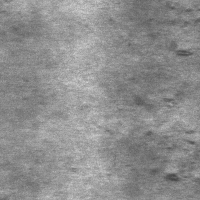

True class: rolled
Predicted class: pitted
Prediction is INCORRECT


In [15]:
image_file = os.path.join(IMAGES_DIR, "class1/class1 (1).jpg")

display_image(image_file)
prediction = get_image_classification(image_file)
true_class_id = os.path.basename(os.path.dirname(image_file))
true_class = df_classes.loc[df_classes['class_id'] == true_class_id, 'class_labels'].values[0]
print(f"True class: {true_class}\nPredicted class: {prediction}")
print("Prediction is CORRECT" if prediction == true_class else "Prediction is INCORRECT")

Image file to classify: defects_images/class2/class2 (1).jpg


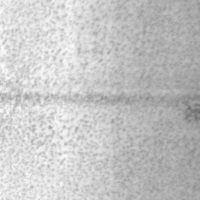

True class: pitted
Predicted class: pitted
Prediction is CORRECT


In [16]:
image_file = os.path.join(IMAGES_DIR, "class2/class2 (1).jpg")

display_image(image_file)
prediction = get_image_classification(image_file)
true_class_id = os.path.basename(os.path.dirname(image_file))
true_class = df_classes.loc[df_classes['class_id'] == true_class_id, 'class_labels'].values[0]
print(f"True class: {true_class}\nPredicted class: {prediction}")
print("Prediction is CORRECT" if prediction == true_class else "Prediction is INCORRECT")

Image file to classify: defects_images/class3/class3 (1).jpg


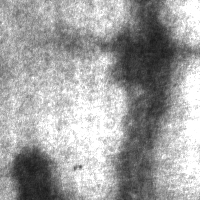

True class: patches
Predicted class: crazing
Prediction is INCORRECT


In [17]:
image_file = os.path.join(IMAGES_DIR, "class3/class3 (1).jpg")

display_image(image_file)
prediction = get_image_classification(image_file)
true_class_id = os.path.basename(os.path.dirname(image_file))
true_class = df_classes.loc[df_classes['class_id'] == true_class_id, 'class_labels'].values[0]
print(f"True class: {true_class}\nPredicted class: {prediction}")
print("Prediction is CORRECT" if prediction == true_class else "Prediction is INCORRECT")

Image file to classify: defects_images/class4/class4 (1).jpg


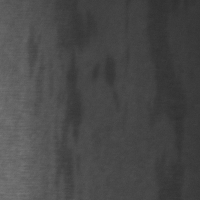

True class: inclusion
Predicted class: patches
Prediction is INCORRECT


In [18]:
image_file = os.path.join(IMAGES_DIR, "class4/class4 (1).jpg")

display_image(image_file)
prediction = get_image_classification(image_file)
true_class_id = os.path.basename(os.path.dirname(image_file))
true_class = df_classes.loc[df_classes['class_id'] == true_class_id, 'class_labels'].values[0]
print(f"True class: {true_class}\nPredicted class: {prediction}")
print("Prediction is CORRECT" if prediction == true_class else "Prediction is INCORRECT")

Image file to classify: defects_images/class5/class5 (1).jpg


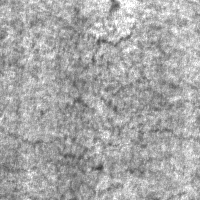

True class: crazing
Predicted class: crazing
Prediction is CORRECT


In [19]:
image_file = os.path.join(IMAGES_DIR, "class5/class5 (1).jpg")

display_image(image_file)
prediction = get_image_classification(image_file)
true_class_id = os.path.basename(os.path.dirname(image_file))
true_class = df_classes.loc[df_classes['class_id'] == true_class_id, 'class_labels'].values[0]
print(f"True class: {true_class}\nPredicted class: {prediction}")
print("Prediction is CORRECT" if prediction == true_class else "Prediction is INCORRECT")

Image file to classify: defects_images/class6/class6 (2).jpg


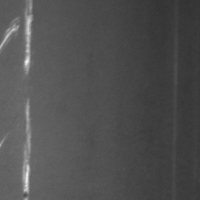

True class: scratches
Predicted class: scratches
Prediction is CORRECT


In [20]:
image_file = os.path.join(IMAGES_DIR, "class6/class6 (2).jpg")

display_image(image_file)
prediction = get_image_classification(image_file)
true_class_id = os.path.basename(os.path.dirname(image_file))
true_class = df_classes.loc[df_classes['class_id'] == true_class_id, 'class_labels'].values[0]
print(f"True class: {true_class}\nPredicted class: {prediction}")
print("Prediction is CORRECT" if prediction == true_class else "Prediction is INCORRECT")

## 3 Using Azure OpenAI gpt-4o baseline model on our images

In [21]:
results = []
idx = 1
samples = 200  # number of the first n samples images per class

for root, dirs, files in os.walk(IMAGES_DIR):
    nb = 1
    for file in files:
        file_path = os.path.join(root, file)
        try:
            if nb <= samples:  # first n samples
                # True label
                true_labels = df_classes.loc[df_classes['class_id'] ==
                                             os.path.basename(root),
                                             'class_labels'].values[0]
                # Predicted label with Azure OpenAI GPT-4o baseline model
                predicted_labels = get_image_classification(file_path)
                print(f"{idx:3} {file_path:50} True label = {true_labels:20} Gpt-4o Predicted label = {predicted_labels}")
                results.append({
                    "filename": file,
                    "true_labels": true_labels,
                    "predicted_labels": predicted_labels
                })
                idx += 1
            nb += 1

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

print("\nDone")

  1 defects_images/class1/class1 (1).jpg               True label = rolled               Gpt-4o Predicted label = pitted
  2 defects_images/class1/class1 (10).jpg              True label = rolled               Gpt-4o Predicted label = pitted
  3 defects_images/class1/class1 (100).jpg             True label = rolled               Gpt-4o Predicted label = pitted
  4 defects_images/class1/class1 (101).jpg             True label = rolled               Gpt-4o Predicted label = pitted
  5 defects_images/class1/class1 (102).jpg             True label = rolled               Gpt-4o Predicted label = pitted
  6 defects_images/class1/class1 (103).jpg             True label = rolled               Gpt-4o Predicted label = pitted
  7 defects_images/class1/class1 (104).jpg             True label = rolled               Gpt-4o Predicted label = pitted
  8 defects_images/class1/class1 (105).jpg             True label = rolled               Gpt-4o Predicted label = pitted
  9 defects_images/class1/class1

In [22]:
df = pd.DataFrame(results)
df

,filename,true_labels,predicted_labels
0,class1 (1).jpg,rolled,pitted
1,class1 (10).jpg,rolled,pitted
2,class1 (100).jpg,rolled,pitted
3,class1 (101).jpg,rolled,pitted
4,class1 (102).jpg,rolled,pitted
...,...,...,...
1195,class6 (44).jpg,scratches,scratches
1196,class6 (45).jpg,scratches,scratches
1197,class6 (46).jpg,scratches,scratches
1198,class6 (47).jpg,scratches,scratches


In [23]:
df['true_labels'].value_counts(sort=False)

true_labels
rolled       200
pitted       200
patches      200
inclusion    200
crazing      200
scratches    200
Name: count, dtype: int64

True label distribution


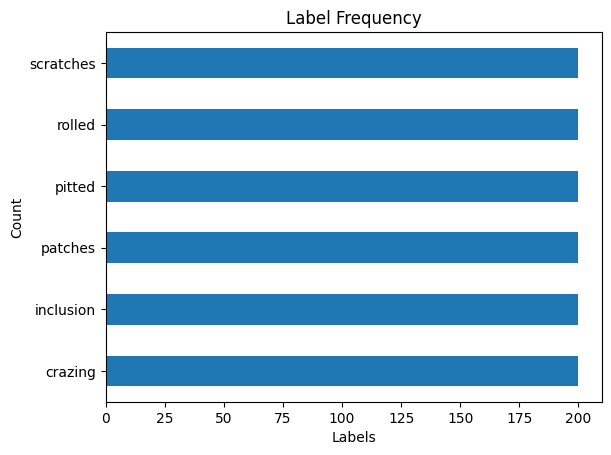

In [24]:
print("True label distribution")

df['true_labels'].value_counts(sort=False).sort_index().plot(kind='barh')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Frequency')
plt.show()

In [25]:
df['predicted_labels'].value_counts(sort=False)

predicted_labels
pitted       474
scratches    355
unknown       30
'pitted'       1
crazing      222
inclusion     25
patches       87
rolled         6
Name: count, dtype: int64

Predicted labels distribution using Azure OpenAI gpt-4o base model


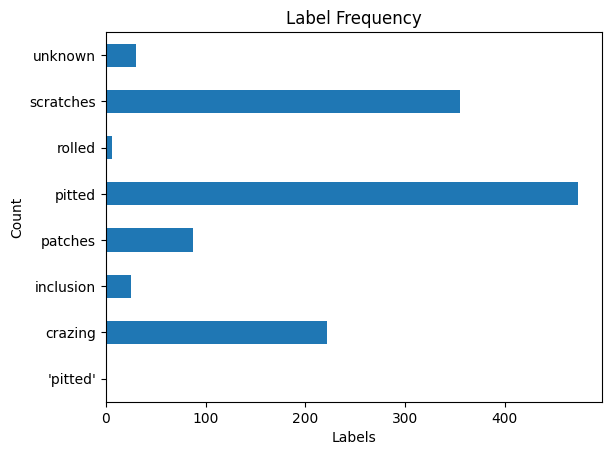

In [26]:
print("Predicted labels distribution using Azure OpenAI gpt-4o base model")

df['predicted_labels'].value_counts(sort=False).sort_index().plot(kind='barh')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Frequency')
plt.show()

### Confusion matrix

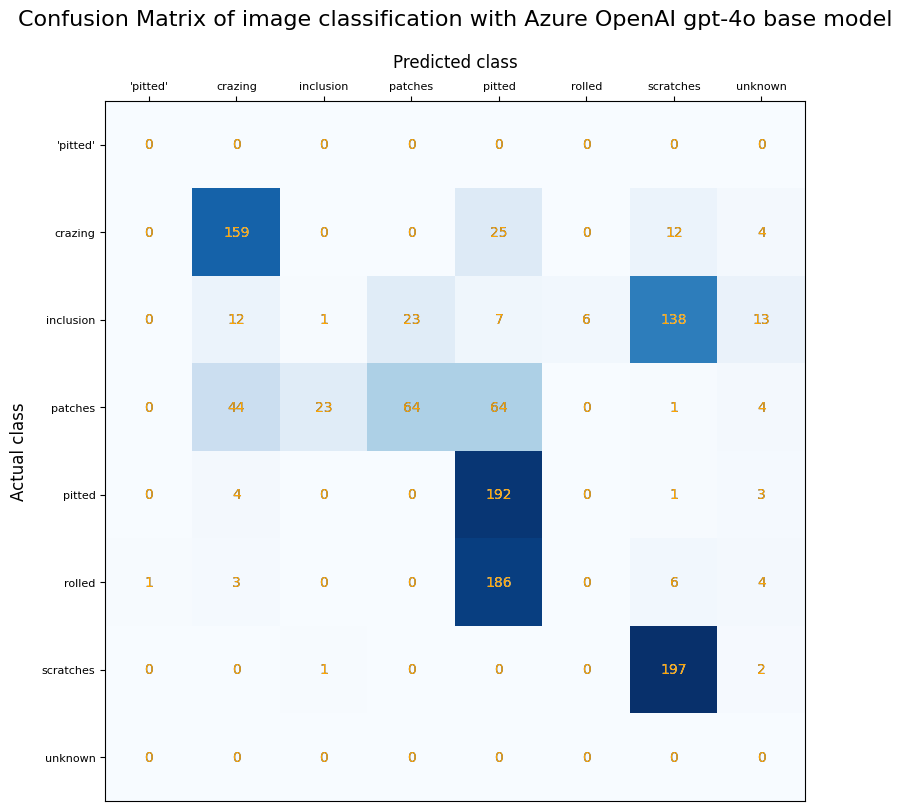

In [32]:
y_true = df[['true_labels']].to_numpy()
y_pred = df[['predicted_labels']].to_numpy()
labels = np.unique(np.concatenate([y_true, y_pred]))

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

for (i, j), value in np.ndenumerate(cm):
    ax.text(j,
            i,
            f"{value}",
            ha="center",
            va="center",
            fontsize=10,
            color="orange")

ax.set_title("Confusion Matrix of image classification with Azure OpenAI gpt-4o base model",
             fontsize=16,
             pad=20)

ax.set_xlabel("Predicted class", fontsize=12, labelpad=10)
ax.set_ylabel("Actual class", fontsize=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticks(np.arange(len(class_labels)), minor=True)
ax.set_yticks(np.arange(len(class_labels)), minor=True)
ax.grid(which="minor", color="black", linestyle="--", linewidth=1)
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.15, right=0.85)
plt.show()

In [28]:
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

    'pitted'       0.00      0.00      0.00         0
     crazing       0.72      0.80      0.75       200
   inclusion       0.04      0.01      0.01       200
     patches       0.74      0.32      0.45       200
      pitted       0.41      0.96      0.57       200
      rolled       0.00      0.00      0.00       200
   scratches       0.55      0.98      0.71       200
     unknown       0.00      0.00      0.00         0

    accuracy                           0.51      1200
   macro avg       0.31      0.38      0.31      1200
weighted avg       0.41      0.51      0.41      1200



In [29]:
accuracy = np.diag(cm).sum() / cm.sum()
print(f"GPT-4o baseline model accuracy = {accuracy:.2}")

GPT-4o baseline model accuracy = 0.51


## 4 Conclusion

We can see that the model is struggling to accurately classify the images without prior training on similar images. Here are some reasons why this might be happening and why fine-tuning is necessary:

- **Unique Characteristics**: The special images might have unique features or patterns that the model hasn't encountered before. Without specific training, the model can't recognize or interpret these features correctly, leading to poor classification results.
- **Complexity**: These images might be more complex or contain more detailed information than the model is used to handling. Zero-shot classification relies on the model's ability to generalize from its training data, but highly complex images can exceed its generalization capabilities.
- **Domain-Specific Knowledge**: The images might belong to a specific domain or context that the model isn't familiar with. For example, medical images, satellite images, or specialized scientific diagrams require domain-specific knowledge that the model lacks without targeted training.
- **Fine Details**: The images might contain fine details or subtle differences that are crucial for accurate classification. Without training on similar images, the model might miss these details and make incorrect classifications.
- **Noise and Variability**: The images might have a lot of noise or variability, such as different lighting conditions, angles, or backgrounds. This variability can confuse the model if it hasn't been trained to handle such variations.
- **Fine-tuning the model on a dataset that includes these special images can significantly improve its performance**. Fine-tuning involves training the model on a smaller, specific dataset that is representative of the new images. This process helps the model learn the unique features, patterns, and context of the special images, leading to better classification accuracy.

In summary, while zero-shot classification is a powerful technique, it has its limitations, especially with unique or complex images. Fine-tuning the model is essential to achieve better results and ensure accurate classifications for these special images.